```
This notebook sets up baroclinic drifters in the Oslofjord
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 9e2194949a236a78754252e0e34f69f9b1e1823f on branch reduced_gravity


# Oslofjord: Baroclinic Drifters

This files sets up exemplary drifter scenario, but for running the script `Oslofjord-run_bcdrift.py` should be used. In the second part of this notebook the outputs can be postprocessed.

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [5]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"
source_url = "/lustre/storeB/project/fou/hi/FjordOs/geogrid_tmp/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [6]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [7]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (eta_rho: 741, eta_v: 740, ocean_time: 720, s_rho: 42, s_w: 43, xi_rho: 397, xi_u: 396)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, eta_v, xi_rho, xi_u
Data variables: (12/17)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    Uwind       (ocean_time, eta_rho, xi_rho) float32 ...
    Vwind       (ocean_time, eta_rho, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

Animation utils

In [8]:
import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [9]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

Simulation span: 6h!

In [10]:
t_start = 5*24 + 20
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

In [11]:
datetime.datetime.strftime(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start]), "%Y-%m-%d %H:00")

'2014-07-06 09:00'

Generating wind fields

In [12]:
from gpuocean.utils import WindStress

def rotate_wind_field(wind, angle, plot=False):
    radians = (angle/360)*2*np.pi
    wind_u = wind.wind_u.copy()
    wind_v = wind.wind_v.copy()
    t = wind.t.copy()
    #print(t)

    c = np.cos(radians)
    s = np.sin(radians)
    wind_u_new = wind_u * c - wind_v * s
    wind_v_new = wind_u * s + wind_v * c

    if plot:
        x0, x1 = 200, 220
        y0, y1 = 200, 220

        fig = plt.figure()
        plt.quiver(wind_u[3, y0:y1, x0:x1], wind_v[3, y0:y1, x0:x1])

        fig = plt.figure()
        plt.quiver(wind_u_new[3, y0:y1, x0:x1], wind_v_new[3, y0:y1, x0:x1])
    return WindStress.WindStress(t=t, wind_u=wind_u_new, wind_v=wind_v_new)

#### Baroclinic Simulations

In [13]:
_, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.0, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

In [86]:
ref_wind = ref_baroclinic_data_args["wind"]
ref_wind.wind_u[ref_wind.wind_u > 1e3] = 0.0
ref_wind.wind_v[ref_wind.wind_v > 1e3] = 0.0

Checking wind

In [112]:
Uwind = np.ma.array(ref_wind.wind_u, mask=7*[1-nc["mask_rho"][y0:y1,x0:x1]])
Vwind = np.ma.array(ref_wind.wind_v, mask=7*[1-nc["mask_rho"][y0:y1,x0:x1]])

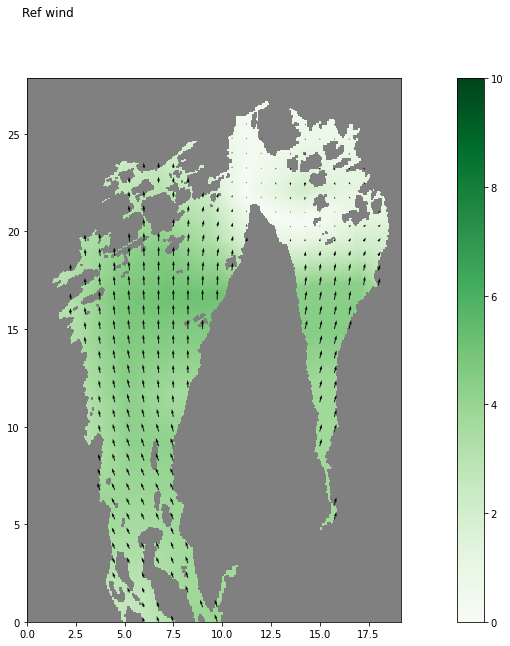

In [115]:
t_idx = 6

initV = np.ma.sqrt(Uwind[t_idx]**2 + Vwind[t_idx]**2)

frequency_x =15
frequency_y =15
x = np.arange(0, initV.shape[1], frequency_x)*ref_baroclinic_data_args["dx"]/1000
y = np.arange(0, initV.shape[0], frequency_y)*ref_baroclinic_data_args["dy"]/1000
qu = Uwind[t_idx][::frequency_y, ::frequency_x]
qv = Vwind[t_idx][::frequency_y, ::frequency_x]

domain_extent = [0, ref_baroclinic_data_args["nx"]*ref_baroclinic_data_args["dx"]/1000,
                     0, ref_baroclinic_data_args["ny"]*ref_baroclinic_data_args["dy"]/1000]

cmap_cp = copy.copy(plt.cm.Greens)
cmap_cp.set_bad("grey", alpha = 1.0)

fig, ax = plt.subplots(1,1,figsize=(20,10))
fig.suptitle("Ref wind")

im = ax.imshow(initV, cmap=cmap_cp, extent=domain_extent, vmin=0.0, vmax=10)
plt.colorbar(im, ax=ax)

ax.quiver(x, y, qu, qv)

In [116]:
ref_baroclinic_data_args["wind"] = ref_wind
ref_baroclinic_data_args["wind_stress_factor"] = 0.3

In [117]:
ref_baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args), dt=0.0, write_netcdf=True)

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [w

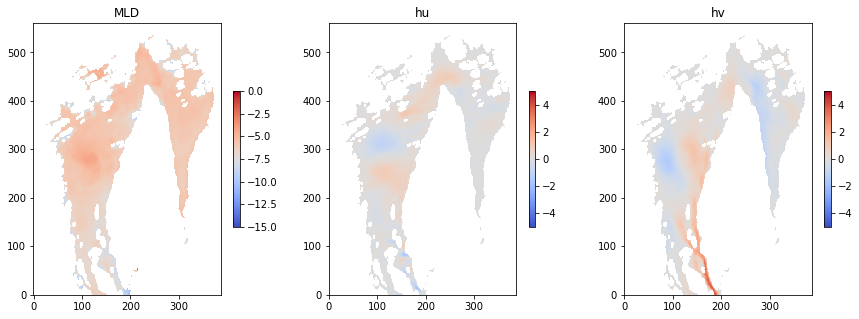

In [118]:
bc_eta, bc_hu, bc_hv = ref_baroclinic_sim.download()

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(-bc_eta, vmin=-15, vmax=0, cmap="coolwarm")
axs[0].set_title("MLD")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(bc_hu, vmin=-5, vmax=5, cmap="coolwarm")
axs[1].set_title("hu")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(bc_hv, vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("hv")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [119]:
subt = 3600
for runt in range(int(T/subt)):
    ref_baroclinic_sim.step(subt)

In [120]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(ref_baroclinic_sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
#     anim.save("anims/baroclinic_test.mp4")

## Baroclinic Drifters

In [ ]:
import pandas as pd 

In [ ]:
baroclinic_wind_angles_degs = np.arange(35, 56, 5)
baroclinic_wind_samples = [None]*len(baroclinic_wind_angles_degs)

for i in range(len(baroclinic_wind_angles_degs)):
    baroclinic_wind_samples[i] = generate_wind_field(baroclinic_wind_angles_degs[i], t_start, T)

In [ ]:
# Mixed layer depth (MLD) 
# Can be explored coupled or decoupled with the reduced gravity constant
mld_dens_samples = np.arange(1022.5, 1024.6, 0.50)
mld_samples_data_args = [None]*len(mld_dens_samples)

for i in range(len(mld_dens_samples)):
    _, mld_samples_data_args[i] = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 
                                                                                    mld_dens_samples[i], timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
    print(mld_samples_data_args[i]["g"])


In [ ]:
wind_stress_samples = np.arange(0.1, 0.51, 0.1)

In [ ]:
friction_samples = np.arange(0, 0.0051, 0.001)

In [ ]:
windage_samples = np.arange(0.0, 0.051, 0.01)

#### Creating simulators

In [ ]:
baroclinic_sims = []
bc_table = pd.DataFrame(columns=["baroclinic_id", "wind_angle_id", "wind_stress_factor_id", "friction_id", "mld_id"]).set_index("baroclinic_id")

for i_w in range(len(baroclinic_wind_samples)):
    for i_ws in range(len(wind_stress_samples)):
        for i_f in range(len(friction_samples)):
            for i_mld in range(len(mld_samples_data_args)):
                baroclinic_data_args = copy.copy(mld_samples_data_args[i_mld])
                baroclinic_data_args["wind"] = baroclinic_wind_samples[i_w]
                baroclinic_data_args["wind_stress_factor"] = wind_stress_samples[i_ws]
                baroclinic_data_args["r"] = friction_samples[i_f]

                baroclinic_sims.append( CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0))
                
                bc_table.loc[len(bc_table.index)] = [i_w, i_ws, i_f, i_mld]

In [ ]:
bc_table

In [ ]:
ref_table = pd.DataFrame(columns=["drifter_id", "baroclinic_id", "windage_id"]).set_index("drifter_id")


for bc in range(len(baroclinic_sims)):
    for windage in range(len(windage_samples)):
        ref_table.loc[len(ref_table.index)] = [bc, windage]

ref_table

Collecting drifter and observation objects

In [ ]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [ ]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_baroclinic_sim.nx, 'ny': ref_baroclinic_sim.ny,
                'domain_size_x': ref_baroclinic_sim.nx*ref_baroclinic_sim.dx,
                'domain_size_y': ref_baroclinic_sim.ny*ref_baroclinic_sim.dy,
                'land_mask': ref_baroclinic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)


In [ ]:
crossprod_trajectories = []
for cp in range(len(ref_table)):
    crossprod_trajectories.append(copy.deepcopy(trajectories))

In [ ]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

num_drifters = len(initx)

In [ ]:
crossprod_drifters = []
for cp in range(len(ref_table)): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(baroclinic_gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = ref_baroclinic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = ref_baroclinic_sim.gpu_stream, # Get re-set in attachment to simulation!
                                                    wind = ref_baroclinic_data_args["wind"],
                                                    wind_drift_factor = windage_samples[ref_table.iloc[cp].windage_id]
                                                    )           

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossprod_drifters.append(drifters)

Attach CPdrifters

In [ ]:
from itertools import compress

In [ ]:
for bc in range(len(baroclinic_sims)):
    baroclinic_sims[bc].attachCrossProductDrifters( 
        list(compress(crossprod_drifters, ref_table["baroclinic_id"] == bc)), 
        [None]*len(windage_samples) )

In [ ]:
for d in range(len(crossprod_drifters)):
    crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], 0.0)

Run the drift experiment

In [ ]:
for bc in range(len(baroclinic_sims)):
    drifter_ids = ref_table.index[ref_table["baroclinic_id"]==bc].tolist()
    while baroclinic_sims[bc].t < T:
        baroclinic_sims[bc].step(360)
        for d in drifter_ids:
            crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], baroclinic_sims[bc].t)

In [ ]:
def plot_cp_trajectories(crossprod_trajectories, drifter_id):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)
        domain_extent = [0, ref_baroclinic_sim.nx*ref_baroclinic_sim.dx/1000, 0, ref_baroclinic_sim.ny*ref_baroclinic_sim.dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(ref_baroclinic_sim.download()[0] > -10, interpolation="none", origin='lower', 
                        cmap=bg_cmap,  
                        extent=domain_extent)

        path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0, T, in_km = True)[0]
        start_pos = path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.01, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        for path in [t.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
            
            ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=0.1)
            
            end_pos = path[-1,:]
            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

        plt.tight_layout()

        plt.savefig("figs/CPdrift"+str(drifter_id)+".pdf", bbox_inches="tight")

In [ ]:
for drifter_id in range(num_drifters):
    plot_cp_trajectories(crossprod_trajectories, drifter_id)

In [ ]:
os.makedirs("pickles", exist_ok=True)
for cp in range(len(crossprod_trajectories)):
    crossprod_trajectories[cp].to_pickle("pickles/cp_trajectory"+str(cp))


In [ ]:
STOP

## Post-Processing

In [ ]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [ ]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

In [ ]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [ ]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

In [ ]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [ ]:
nx = (x1-x0)
ny = (y1-y0)
dx, dy = 50.0, 50.0

In [ ]:
from gpuocean.utils import Observation

In [ ]:
timestamp = "2023-04-12T11_19_41"

trajectories = []

for f in os.listdir('pickles/'+timestamp):
    obs= Observation.Observation()
    obs.read_pickle('pickles/'+timestamp+'/'+ f )
    trajectories.append( obs )

OpenDrift (loading from file)

In [ ]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

In [ ]:
lats = nc["lat_rho"][y0:y1,x0:x1]
lons = nc["lon_rho"][y0:y1,x0:x1]

def xy2latlon(x,y, dx=50.0, dy=50.0):
    local_index_x = x/dx + 0.5
    local_index_y = y/dy + 0.5

    def _interp(field, local_index_x, local_index_y):
        local_index_x_lower = int(local_index_x)
        local_index_x_upper = int(local_index_x)+1

        local_index_y_lower = int(local_index_y)
        local_index_y_upper = int(local_index_y)+1

        val00 = (1 - (local_index_x - local_index_x_lower))*(1 - (local_index_y - local_index_y_lower)) * field[local_index_y_lower, local_index_x_lower]
        val01 = (1 - (local_index_x - local_index_x_lower))*(local_index_y - local_index_y_lower) * field[local_index_y_upper, local_index_x_lower]
        val10 = (local_index_x - local_index_x_lower)*(1 - (local_index_y - local_index_y_lower)) * field[local_index_y_lower, local_index_x_upper]
        val11 = (local_index_x - local_index_x_lower)*(local_index_y - local_index_y_lower) * field[local_index_y_upper, local_index_x_upper]
        return val00 + val01 + val10 + val11 
    
    return (_interp(lats, local_index_x, local_index_y), _interp(lons, local_index_x, local_index_y))

[xy2latlon(x, y) for x,y in list(zip(initx,inity))]

In [ ]:
fig, ax = plt.subplots()
ax.imshow(nc["mask_rho"][y0:y1,x0:x1], extent=[lons.min(), lons.max(), lats.min(), lats.max()])
for i in range(len(initx)):
    latlon = xy2latlon(initx[i],inity[i])
    ax.scatter(latlon[1], latlon[0])

In [ ]:
def latlon2xy(lat, lon, dx=50.0, dy=50.0):
    penalty = (lats - lat)**2 + (lons - lon)**2
    idx_y, idx_x = np.argwhere( penalty==penalty.min() )[0]

    if lats[idx_y, idx_x] > lat:
        idx_y_lower = idx_y-1
        idx_y_upper = idx_y 
    else:
        idx_y_lower = idx_y 
        idx_y_upper = idx_y+1

    if lons[idx_y, idx_x] > lon:
        idx_x_lower = idx_x-1
        idx_x_upper = idx_x 
    else:
        idx_x_lower = idx_x  
        idx_x_upper = idx_x+1

    y = idx_y_lower + (lat - lats[idx_y_lower, idx_x])/(lats[idx_y_upper, idx_x] - lats[idx_y_lower, idx_x])
    x = idx_x_lower + (lon - lons[idx_y, idx_x_lower])/(lons[idx_y, idx_x_upper] - lons[idx_y, idx_x_lower])

    return (y-0.5)*dy, (x-0.5)*dx

In [ ]:
import pickle
with open("fjordos_opendrift_trajectories_000.pickle", "rb") as f:
    opendrift_results = pickle.load(f)

In [ ]:
fig, ax = plt.subplots(1,1, )
domain_extent = [nc["lon_rho"][y0:y1,x0:x1].min(), nc["lon_rho"][y0:y1,x0:x1].max(), nc["lat_rho"][y0:y1,x0:x1].min(), nc["lat_rho"][y0:y1,x0:x1].max()]
ax.imshow(1-nc["mask_rho"][y0:y1,x0:x1], extent=domain_extent, cmap="Reds")
for i in range(len(opendrift_results["lon"])):
    ax.plot(opendrift_results["lon"][i], opendrift_results["lat"][i])

In [ ]:
fig, ax = plt.subplots(1,1)
domain_extent = [0, (x1-x0)*50.0/1000, 0, (y1-y0)*50.0/1000]
ax.imshow(1-nc["mask_rho"][y0:y1,x0:x1], extent=domain_extent, cmap="Reds")
for d in range(len(opendrift_results["lon"])):
    print(d)
    path = np.zeros((len(opendrift_results["lat"][d]),2))
    for l in range(len(opendrift_results["lat"][d])):
        if opendrift_results["lat"][d][l]:
            path[l] = latlon2xy(opendrift_results["lat"][d][l], opendrift_results["lon"][d][l])
        else:
            path[l] = path[l-1]
    ax.plot(path[:,1]/1000,path[:,0]/1000)

In [ ]:
o_trajectories = []

o_wind_drift_factors = ["000", "015", "030"]
for o_factor in o_wind_drift_factors:
    with open("fjordos_opendrift_trajectories_"+o_factor+".pickle", "rb") as f:
        opendrift_results = pickle.load(f)

    o_trajectory = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=1-nc["mask_rho"][y0:y1,x0:x1])

    ts = [(t - opendrift_results["time"][0]).seconds for t in opendrift_results["time"]]

    X = np.zeros((len(opendrift_results["lat"]), len(opendrift_results["time"])))
    Y = np.zeros((len(opendrift_results["lat"]), len(opendrift_results["time"])))

    for d in range(len(opendrift_results["lon"])):
        for l in range(len(opendrift_results["lat"][d])):
            if opendrift_results["lat"][d][l]:
                xy = latlon2xy(opendrift_results["lat"][d][l], opendrift_results["lon"][d][l])
                X[d,l], Y[d,l] = xy[1], xy[0]
            else:
                X[d,l], Y[d,l] = X[d,l-1], Y[d,l-1]

    o_trajectory.add_observations_from_arrays(ts, X, Y)

    o_trajectories.append(o_trajectory)

Plotting

In [ ]:
def plot_cp_trajectories(drifter_id, crossprod_trajectories, o_trajectories=None):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        domain_extent = [0, (x1-x0)*50.0/1000, 0, (y1-y0)*50.0/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap, extent=domain_extent, zorder=-10)
        
        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(10, 12, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(58, 62, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e


        T = crossprod_trajectories[0].obs_df.iloc[-1].time
        dummy_path = crossprod_trajectories[0].get_drifter_path(0, 0,  T, in_km = True)[0]
        start_pos = dummy_path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.01, color = 'black', fill=True, zorder=2)
        ax.add_patch(circ_start)      

        # Save paths to array
        num_results = len(crossprod_trajectories)
        X = np.zeros((dummy_path.shape[0], num_results))
        Y = np.zeros((dummy_path.shape[0], num_results))

        counter=0
        for path in [t.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
            try:
                X[:,counter] = np.minimum(np.maximum(0, path[:,0]), (x1-x0)*50.0/1000)
                Y[:,counter] = np.minimum(np.maximum(0, path[:,1]), (y1-y0)*50.0/1000)
                counter+=1
            except:
                pass

        # Plot paths from array
        ax.plot(X, Y, color="C0", ls="-", zorder=-3, alpha=0.05) #, rasterized=True)
        ax.scatter(X[-1,:], Y[-1, :], marker='x', color='black', s=2, linewidths=2, zorder=-4)# , rasterized=True)

        # Plot opendrift paths
        if o_trajectories is not None:
            for opath in [ot.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for ot in o_trajectories]:
                ax.plot(opath[:,0], opath[:,1], color="C1", ls="-", zorder=1)



        plt.tight_layout()
        ax.set_rasterization_zorder(0)
        plt.savefig("figs/"+timestamp+"/BCdrift"+str(drifter_id)+"_rasterised.pdf", bbox_inches="tight", dpi=400)

In [ ]:
len(trajectories)

In [ ]:
plot_cp_trajectories(5, trajectories, o_trajectories)

In [ ]:
numDrifters = len(trajectories[0].obs_df.iloc[0].drifter_positions)
for d in range(numDrifters):
    plot_cp_trajectories(d, trajectories, o_trajectories)

In [ ]:
def plot_cp_kde(drifter_id, trajectories, o_trajectories):

    # Space and time 
    nx = (x1-x0)
    ny = (y1-y0)

    dx = 50.0
    dy = 50.0

    T = trajectories[0].obs_df.iloc[-1].time

    ## Get last postions
    numTrajectories = len(trajectories)

    last_positions = np.zeros((numTrajectories,2))
    for d in range(numTrajectories):
        last_positions[d] = trajectories[d].get_drifter_path(drifter_id, 0, T)[-1][-1]

    # Axes
    x = np.arange(nx)*dx
    y = np.arange(ny)*dy
    x/=1000
    y/=1000
    xx, yy = np.meshgrid(x,y)
    ccs = np.vstack([xx.ravel(), yy.ravel()])

    ## Kernel density estimation 
    clp = (last_positions-np.average(last_positions,axis=0)).T
    clp[0][clp[0] > (x[-1]/2)] = clp[0][clp[0] > (x[-1]/2)] - x[-1]
    clp[0][clp[0] < (-x[-1]/2)] = clp[0][clp[0] < (-x[-1]/2)] + x[-1]
    clp[1][clp[1] > (y[-1]/2)] = clp[1][clp[1] > (y[-1]/2)] - y[-1]
    clp[1][clp[1] < (-y[-1]/2)] = clp[1][clp[1] < (-y[-1]/2)] + y[-1]

    raw_cov = np.cov(clp)

    bw = 100**(-1./(2+4)) #* 0.5 #for whtatever reason scipy.stats.gaussian_kde is roughly half of that

    cov = raw_cov * bw
    covinv = np.linalg.inv(cov)

    f = np.ma.array(np.zeros((ny,nx)), mask=1-nc["mask_rho"][y0:y1,x0:x1])

    sea_mask = np.array(nc["mask_rho"][y0:y1,x0:x1], dtype=bool)
    for e in range(numTrajectories):
        d = (ccs.T-last_positions[e]).T
        d[0][d[0] > (x[-1]/2)] = d[0][d[0] > (x[-1]/2)] - x[-1]
        d[0][d[0] < (-x[-1]/2)] = d[0][d[0] < (-x[-1]/2)] + x[-1]
        d[1][d[1] > (y[-1]/2)] = d[1][d[1] > (y[-1]/2)] - y[-1]
        d[1][d[1] < (-y[-1]/2)] = d[1][d[1] < (-y[-1]/2)] + y[-1]
        temp_f = np.exp(-1/2*np.sum((d*np.dot(covinv,d)), axis=0)).reshape(ny,nx)
        temp_mass = np.sum(temp_f)
        temp_sea_mass = np.sum(temp_f[sea_mask])
        f += temp_mass/temp_sea_mass * temp_f
        
    ## Levels for plotting
    fmass = np.sum(f)

    fmax = np.max(f)
    levels = np.linspace(0,fmax,100)
    level_probs = np.zeros(100)
    for l in range(len(levels)):
        level_probs[l] = np.sum(f[f>levels[l]])/fmass
    level_probs[-1] = 0.0

    desired_probs = [0.9,0.75,0.5,0.25,0.0] #descending! (ending with 0.0)
    desired_levels = np.zeros_like(desired_probs)
    for p in range(len(desired_probs)):
        desired_levels[p] = levels[np.abs(level_probs-desired_probs[p]).argmin()]
    desired_levels = np.unique(desired_levels)

    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        ## Contour plots
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap, extent=domain_extent, zorder=2)

        cfset = ax.contourf(xx, yy, f, levels=desired_levels, cmap='Greens', alpha=0.5, zorder=3)
        cset = ax.contour(xx, yy, f, levels=desired_levels, colors='k', alpha=0.25, linewidths=1, zorder=4)

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(10, 12, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(58, 62, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e

        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cfset.collections]
        labels = []
        for p in desired_probs:
            labels.append(str(int(p*100))+"%")
        ax.legend(proxy, labels, prop={'size': 26}, labelcolor="black", loc=4, framealpha=0.9)


        # Plot opendrift paths
        if o_trajectories is not None:
            dummy_path = o_trajectories[0].get_drifter_path(drifter_id, 0,  T, in_km = True)[0]
            start_pos = dummy_path[0,:]
            circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                    0.01, color = 'black', fill=True, zorder=2)
            ax.add_patch(circ_start)      
            for opath in [ot.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for ot in o_trajectories]:
                ax.plot(opath[:,0], opath[:,1], color="C1", ls="-", zorder=1)


        plt.savefig("figs/"+timestamp+"/BCkde"+str(drifter_id)+".pdf", bbox_inches="tight")


In [ ]:
numDrifters = len(trajectories[0].obs_df.iloc[0].drifter_positions)
for d in range(numDrifters):
    plot_cp_kde(d, trajectories)